# Wikimedia Research - Translation Imbalances: Testing hypothesis #2

# 1. Tests

#### Initial test with dumps

In [ ]:
# import libraries here
import gzip  # necessary for decompressing dump file into text format
import pandas as pd
import numpy as np

__NOTE__: The MediaWiki API can be language specific. We can use it to contruct the relevant datasets of the users we need. The following will yield different results:
- https://es.wikipedia.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount
- https://de.wikipedia.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount
- https://www.mediawiki.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount&format=json

In [19]:
import requests

url = "https://www.mediawiki.org/w/api.php?action=query&list=users&ususers=Adamw&usprop=editcount&format=json"

# Making a GET request
response = requests.get(url)
# See status code
print(response.status_code)
# See request text
print(response.text)

response.json()


200
{"batchcomplete":"","query":{"users":[{"userid":398607,"name":"Adamw","editcount":1507}]}}


{'batchcomplete': '',
 'query': {'users': [{'userid': 398607, 'name': 'Adamw', 'editcount': 1507}]}}

In [20]:
import requests

url = "https://en.wikipedia.org/w/rest.php/v1/search/page?q=earth&limit=1"

# Making a GET request
response = requests.get(url)
# See URL
response.url
# See status code
response.status_code
# See request header
response.text


'{"pages":[{"id":9228,"key":"Earth","title":"Earth","excerpt":"<span class=\\"searchmatch\\">Earth</span> is the third planet from the Sun and the only place known in the universe where life has originated and found habitability. <span class=\\"searchmatch\\">Earth</span> is the only planet","matched_title":null,"description":"Third planet from the Sun","thumbnail":{"mimetype":"image/jpeg","width":60,"height":60,"duration":null,"url":"//upload.wikimedia.org/wikipedia/commons/thumb/c/cb/The_Blue_Marble_%28remastered%29.jpg/60px-The_Blue_Marble_%28remastered%29.jpg"}}]}'

# 2. Implementation

## Data collection

In [77]:
# import general libraries
import csv
import ast
import re
import requests
import pandas as pd

In [78]:
# we are adding this list because the CSV files includes items that are not in it
allowed_languages = ['aa', 'ab', 'ace', 'ady', 'af', 'ak', 'als', 'alt', 'am', 'ami', 'an', 'ang', 'ar', 'arc', 'ary',
                     'arz', 'as', 'ast', 'atj', 'av', 'avk', 'awa', 'ay', 'az', 'azb', 'ba', 'ban', 'bar', 'bat-smg',
                     'bcl', 'be', 'be-tarask', 'bg', 'bh', 'bi', 'bjn', 'blk', 'bm', 'bn', 'bo', 'bpy', 'br', 'bs',
                     'bug', 'bxr', 'ca', 'cbk-zam', 'cdo', 'ce', 'ceb', 'ch', 'cho', 'chr', 'chy', 'ckb', 'co', 'cr',
                     'crh', 'cs', 'csb', 'cu', 'cv', 'cy', 'da', 'dag', 'de', 'din', 'diq', 'dsb', 'dty', 'dv', 'dz',
                     'ee', 'el', 'eml', 'en', 'eo', 'es', 'et', 'eu', 'ext', 'fa', 'ff', 'fi', 'fiu-vro', 'fj', 'fo', 
                     'gur', 'fr', 'frp', 'frr', 'fur', 'fy', 'ga', 'gag', 'gan', 'gcr', 'gd', 'gl', 'glk', 'gn', 'gom',
                     'gor', 'got', 'gu', 'guw', 'gv', 'ha', 'hak', 'haw', 'he', 'hi', 'hif', 'ho', 'hr', 'hsb', 'ht', 
                     'hu', 'hy', 'hyw', 'hz', 'ia', 'id', 'ie', 'ig', 'ii', 'ik', 'ilo', 'inh', 'io', 'is', 'it', 'iu',
                     'ja', 'jam', 'jbo', 'jv', 'ka', 'kaa', 'kab', 'kbd', 'kbp', 'kcg', 'kg', 'ki', 'kj', 'kk', 'kl', 
                     'km', 'kn', 'ko', 'koi', 'kr', 'krc', 'ks', 'ksh', 'ku', 'kv', 'kw', 'ky', 'la', 'lad', 'lb', 'lbe', 
                     'lez', 'lfn', 'lg', 'li', 'lij', 'lld', 'lmo', 'ln', 'lo', 'lrc', 'lt', 'ltg', 'lv', 'mad', 'mai', 
                     'map-bms', 'mdf', 'mg', 'mh', 'mhr', 'mi', 'min', 'mk', 'ml', 'mn', 'mni', 'mnw', 'mr', 'mrj', 'ms',
                     'mt', 'mus', 'mwl', 'my', 'myv', 'mzn', 'na', 'nah', 'nap', 'nds', 'nds-nl', 'ne', 'new', 'ng', 'nia',
                     'nl', 'nn', 'no', 'nov', 'nqo', 'nrm', 'nso', 'nv', 'ny', 'oc', 'olo', 'om', 'or', 'os', 'pa', 'pag',
                     'pam', 'pap', 'pcd', 'pcm', 'pdc', 'pfl', 'pi', 'pih', 'pl', 'pms', 'pnb', 'pnt', 'ps', 'pt', 'pwn',
                     'qu', 'rm', 'rmy', 'rn', 'ro', 'roa-rup', 'roa-tara', 'ru', 'rue', 'rw', 'sa', 'sah', 'sat', 'sc',
                     'scn', 'sco', 'sd', 'se', 'sg', 'sh', 'shi', 'shn', 'si', 'simple', 'sk', 'skr', 'sl', 'smn', 'sm', 
                     'sn', 'so', 'sq', 'sr', 'srn', 'ss', 'st', 'stq', 'su', 'sv', 'sw', 'szl', 'szy', 'ta', 'tay', 'tcy',
                     'te', 'tet', 'tg', 'th', 'ti', 'tk', 'tl', 'tn', 'to', 'tpi', 'tr', 'trv', 'ts', 'tt', 'tum', 'tw', 'ty',
                     'tyv', 'udm', 'ug', 'uk', 'ur', 'uz', 've', 'vec', 'vep', 'vi', 'vls', 'vo', 'wa', 'war', 'guc', 'wo', 'wuu',
                     'xal', 'xh', 'xmf', 'yi', 'yo', 'za', 'zea', 'zh', 'zh-classical', 'zh-min-nan', 'zh-yue', 'zu']

In [79]:
## Collect users and languages
from csv import DictReader

# open file in read mode and convert to list of dictionaries
with open('data/user_languages_user_template.csv', encoding="utf8") as f:
    users = csv.DictReader(f)
    user_dictionary = {}
    
    # make headers lowercase
    users.fieldnames = [h.lower() for h in users.fieldnames]
    
    # iterate over results to initialize copy and set new columns
    for i, row in enumerate(users):

        # initialize fields
        row['edit_counts'] = []
        row['level_lang'] = []
        username = row['username'].split(':')[1]
        row['username'] = username
        
        # update mapper
        user_dictionary[username] =row
    
    
# out
display(users.fieldnames)
display(user_dictionary)    

['username', 'language']

{'Olivier LPB': {'username': 'Olivier LPB',
  'language': "['fr', 'en-2']",
  'edit_counts': [],
  'level_lang': []},
 'Gamesmasterg9': {'username': 'Gamesmasterg9',
  'language': "['en', 'hi-4', 'bn-3', 'mr-1']",
  'edit_counts': [],
  'level_lang': []},
 'Dvermeirre': {'username': 'Dvermeirre',
  'language': "['fr', 'en-5', 'de-1']",
  'edit_counts': [],
  'level_lang': []},
 'Jklamo': {'username': 'Jklamo',
  'language': "['en-3', 'cs', 'sk', 'fr-1']",
  'edit_counts': [],
  'level_lang': []},
 'Calliopejen1': {'username': 'Calliopejen1',
  'language': "['en', 'es-3', 'fr-1']",
  'edit_counts': [],
  'level_lang': []},
 'Jpbrenna': {'username': 'Jpbrenna',
  'language': "['en', 'el-2', 'la-2', 'es-2', 'ar-1']",
  'edit_counts': [],
  'level_lang': []},
 'WarKosign': {'username': 'WarKosign',
  'language': "['en-3', 'he-4', 'ru']",
  'edit_counts': [],
  'level_lang': []},
 'Appaches': {'username': 'Appaches',
  'language': "['fr', 'en-3']",
  'edit_counts': [],
  'level_lang': []},


## Data processing

Some possibilities is to have a dataframe that has 
[username],[language],[level],[edit count] 

In [80]:
## Clean initial data and update rows and prepare data for requests
from collections import defaultdict

# dictionary neede to make request by language and associated user list
language_match_dict = defaultdict(list)
    
for key, row in user_dictionary.items():
    username = row['username']
    languages = ast.literal_eval(row['language'])
    level_lang = []
    edit_keys = set()
    
    for lang in languages:    
        
        # TODO: AW: Push this into a separate function that can be tested.
        # split by digits with a preceding character ('-') and include it
        lang_extract = list(filter(None, re.split('-(\d)|-[A-Z]+', lang)))
        # get the language
        lang = lang_extract[0]
        # get language level if present, else, assume native level
        level = lang_extract[1] if len(lang_extract) > 1 else 5 
        
        if (lang in allowed_languages) and (lang not in edit_keys):
            # append
            level_lang.append((lang, level))
            # initialize key
            edit_keys.add(lang)

            # add to the user to the corresponding language group
            language_match_dict[lang].append(username)
    
    # update row columns after cleaning
    row['level_lang'] = level_lang
    # we are creating a dictionary to easily map and update by user and language after
    # getting the raw counts. We initialize to 0 to only update data that is not 'missing'
    row['edit_counts'] = dict.fromkeys(edit_keys, 0)
    # 'unset' language 
    del row['language']

# out
display(user_dictionary)

{'Olivier LPB': {'username': 'Olivier LPB',
  'edit_counts': {'fr': 0, 'en': 0},
  'level_lang': [('fr', 5), ('en', '2')]},
 'Gamesmasterg9': {'username': 'Gamesmasterg9',
  'edit_counts': {'en': 0, 'bn': 0, 'mr': 0, 'hi': 0},
  'level_lang': [('en', 5), ('hi', '4'), ('bn', '3'), ('mr', '1')]},
 'Dvermeirre': {'username': 'Dvermeirre',
  'edit_counts': {'fr': 0, 'en': 0, 'de': 0},
  'level_lang': [('fr', 5), ('en', '5'), ('de', '1')]},
 'Jklamo': {'username': 'Jklamo',
  'edit_counts': {'en': 0, 'cs': 0, 'fr': 0, 'sk': 0},
  'level_lang': [('en', '3'), ('cs', 5), ('sk', 5), ('fr', '1')]},
 'Calliopejen1': {'username': 'Calliopejen1',
  'edit_counts': {'en': 0, 'fr': 0, 'es': 0},
  'level_lang': [('en', 5), ('es', '3'), ('fr', '1')]},
 'Jpbrenna': {'username': 'Jpbrenna',
  'edit_counts': {'en': 0, 'ar': 0, 'es': 0, 'el': 0, 'la': 0},
  'level_lang': [('en', 5),
   ('el', '2'),
   ('la', '2'),
   ('es', '2'),
   ('ar', '1')]},
 'WarKosign': {'username': 'WarKosign',
  'edit_counts': {'e

In [81]:
langs = list(language_match_dict.keys())
langs

['fr',
 'en',
 'hi',
 'bn',
 'mr',
 'de',
 'cs',
 'sk',
 'es',
 'el',
 'la',
 'ar',
 'he',
 'ru',
 'pt',
 'gom',
 'ko',
 'lt',
 'eo',
 'nl',
 'pa',
 'sa',
 'zh',
 'ja',
 'da',
 'no',
 'sv',
 'ml',
 'nds',
 'sq',
 'mk',
 'af',
 'xh',
 'ta',
 'fa',
 'crh',
 'it',
 'als',
 'sr',
 'gl',
 'ca',
 'ms',
 'id',
 'th',
 'hak',
 'haw',
 'gn',
 'zh-yue',
 'tl',
 'si',
 'ary',
 'arz',
 'fi',
 'zh-classical',
 'sco',
 'pl',
 'mzn',
 'tg',
 'glk',
 'ku',
 'hu',
 'ht',
 'sl',
 'az',
 'ro',
 'hr',
 'min',
 'jv',
 'su',
 'ace',
 'nn',
 'mn',
 'my',
 'bg',
 'mt',
 'pam',
 'tr',
 'ii',
 'bar',
 'uk',
 'ka',
 'ur',
 'as',
 'lo',
 'bs',
 'sh',
 'vec',
 'simple',
 'yi',
 'vi',
 'ckb',
 'am',
 'ilo',
 'pnb',
 'bug',
 'bjn',
 'vls',
 'lad',
 'eu',
 'cy',
 'oc',
 'frp',
 'te',
 'kn',
 'is',
 'gu',
 'hy',
 'gd',
 'lv',
 'ne',
 'ga',
 'wuu',
 'ky',
 'kk',
 'uz',
 'tt',
 'gan',
 'be',
 'sw']

In [87]:
## Per each language, make request to get the data and merge it with larger dictionary
# Reference: https://www.mediawiki.org/w/api.php?action=help&modules=query%2Busers
import traceback
from time import sleep

from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# general
user_edit_counts = {}
langs = list(language_match_dict.keys())

# set requests parameters to retry on 'Max retries exceeded with url' and have enough wait time between exceptions
session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('https://', adapter)

# used to track call number
api_call_number = 0

# initialize
slice_start = 0
slice_end = 50
#lang = langs.pop()
#next_lang = lang
#users_len = len(language_match_dict[lang])

while (len(langs) > 0) or (slice_end < users_len):
    try:
        # check to update slice values
        if slice_end >= users_len:
            print("checking...")
            lang = langs.pop() if langs else lang

            slice_start = 0
            slice_end = 50
            users_len = len(language_match_dict[lang])
        else:
            slice_start = slice_start + 50
            slice_end =  slice_end + 50 
            
        print('\n\n\n')
        print(f"LANG {lang}\nUSERS' LIST SIZE {users_len}")
        # work with uses batches that make request per 50 users within a user language group
        users_l = language_match_dict[lang][slice_start:slice_end]
        users =  "|".join(users_l)
        url = f'https://{lang}.wikipedia.org/w/api.php?action=query&list=users&ususers={users}&usprop=editcount&format=json'
        lang_call = lang    

        # GET request
        response = session.get(url)
        if response.status_code != 200:
            raise Exception(f"The call failed: {response.status_code}")

        else:
            # See request JSON
            res = response.json()['query']['users']
            print(res)

            # save results to dictionary to process later

            # AW: Although I like the encapsulation of each user's fetched
            # information under data/users/, it's more efficient to swap
            # containment levels and instead save a csv for all users' edit
            # counts on a language wiki, at the end of this function.  This
            # is a much smaller number of files, and matches the structure of
            # iteration in program logic which becomes helpful if eg. the
            # application crashes and must be restarted.
            user_edit_counts[lang_call] = res
            print(res)

            api_call_number += 1
            print(f'\n\nLIMIT: {len(users_l)} \n\nCALL NUMBER: {api_call_number}')
            
    
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    
    except Exception as e:
        print(e)
        traceback.print_exc()
      






<<<<<LANGS NOW IS:
 ['fr', 'en', 'hi', 'bn', 'mr', 'de', 'cs', 'sk', 'es', 'el', 'la', 'ar', 'he', 'ru', 'pt', 'gom', 'ko', 'lt', 'eo', 'nl', 'pa', 'sa', 'zh', 'ja', 'da', 'no', 'sv', 'ml', 'nds', 'sq', 'mk', 'af', 'xh', 'ta', 'fa', 'crh', 'it', 'als', 'sr', 'gl', 'ca', 'ms', 'id', 'th', 'hak', 'haw', 'gn', 'zh-yue', 'tl', 'si', 'ary', 'arz', 'fi', 'zh-classical', 'sco', 'pl', 'mzn', 'tg', 'glk', 'ku', 'hu', 'ht', 'sl', 'az', 'ro', 'hr', 'min', 'jv', 'su', 'ace', 'nn', 'mn', 'my', 'bg', 'mt', 'pam', 'tr', 'ii', 'bar', 'uk', 'ka', 'ur', 'as', 'lo', 'bs', 'sh', 'vec', 'simple', 'yi', 'vi', 'ckb', 'am', 'ilo', 'pnb', 'bug', 'bjn', 'vls', 'lad', 'eu', 'cy', 'oc', 'frp', 'te', 'kn', 'is', 'gu', 'hy', 'gd', 'lv', 'ne', 'ga', 'wuu', 'ky', 'kk', 'uz', 'tt', 'gan', 'be', 'sw']
LANG fr
 USERS' LIST SIZE 154
HELLLOOOOO
[{'userid': 156593, 'name': 'Ww2censor', 'editcount': 202}, {'userid': 544208, 'name': 'Sasuke Sarutobi', 'editcount': 0}, {'userid': 1377350, 'name': 'YanikB', 'editcount': 52

[{'userid': 3745155, 'name': 'ABF992', 'editcount': 3}, {'userid': 3409598, 'name': 'Arcoria', 'editcount': 26}, {'userid': 419599, 'name': 'Porantim', 'editcount': 2}, {'userid': 3720941, 'name': 'Kline', 'editcount': 0}]
[{'userid': 3745155, 'name': 'ABF992', 'editcount': 3}, {'userid': 3409598, 'name': 'Arcoria', 'editcount': 26}, {'userid': 419599, 'name': 'Porantim', 'editcount': 2}, {'userid': 3720941, 'name': 'Kline', 'editcount': 0}]


LIMIT: 4 

CALL NUMBER: 3
checking...




<<<<<LANGS NOW IS:
 ['fr', 'en', 'hi', 'bn', 'mr', 'de', 'cs', 'sk', 'es', 'el', 'la', 'ar', 'he', 'ru', 'pt', 'gom', 'ko', 'lt', 'eo', 'nl', 'pa', 'sa', 'zh', 'ja', 'da', 'no', 'sv', 'ml', 'nds', 'sq', 'mk', 'af', 'xh', 'ta', 'fa', 'crh', 'it', 'als', 'sr', 'gl', 'ca', 'ms', 'id', 'th', 'hak', 'haw', 'gn', 'zh-yue', 'tl', 'si', 'ary', 'arz', 'fi', 'zh-classical', 'sco', 'pl', 'mzn', 'tg', 'glk', 'ku', 'hu', 'ht', 'sl', 'az', 'ro', 'hr', 'min', 'jv', 'su', 'ace', 'nn', 'mn', 'my', 'bg', 'mt', 'pam', 'tr',

[{'userid': 39105, 'name': 'AquitaneHungerForce', 'editcount': 0}, {'userid': 30643, 'name': 'Ser!', 'editcount': 11}]
[{'userid': 39105, 'name': 'AquitaneHungerForce', 'editcount': 0}, {'userid': 30643, 'name': 'Ser!', 'editcount': 11}]


LIMIT: 2 

CALL NUMBER: 12
checking...




<<<<<LANGS NOW IS:
 ['fr', 'en', 'hi', 'bn', 'mr', 'de', 'cs', 'sk', 'es', 'el', 'la', 'ar', 'he', 'ru', 'pt', 'gom', 'ko', 'lt', 'eo', 'nl', 'pa', 'sa', 'zh', 'ja', 'da', 'no', 'sv', 'ml', 'nds', 'sq', 'mk', 'af', 'xh', 'ta', 'fa', 'crh', 'it', 'als', 'sr', 'gl', 'ca', 'ms', 'id', 'th', 'hak', 'haw', 'gn', 'zh-yue', 'tl', 'si', 'ary', 'arz', 'fi', 'zh-classical', 'sco', 'pl', 'mzn', 'tg', 'glk', 'ku', 'hu', 'ht', 'sl', 'az', 'ro', 'hr', 'min', 'jv', 'su', 'ace', 'nn', 'mn', 'my', 'bg', 'mt', 'pam', 'tr', 'ii', 'bar', 'uk', 'ka', 'ur', 'as', 'lo', 'bs', 'sh', 'vec', 'simple', 'yi', 'vi', 'ckb', 'am', 'ilo', 'pnb', 'bug', 'bjn', 'vls', 'lad', 'eu', 'cy', 'oc', 'frp', 'te', 'kn', 'is', 'gu', 'hy', 'gd', 'lv']


[{'userid': 11168, 'name': 'Briantin de Montrei', 'editcount': 349}]
[{'userid': 11168, 'name': 'Briantin de Montrei', 'editcount': 349}]


LIMIT: 1 

CALL NUMBER: 21
checking...




<<<<<LANGS NOW IS:
 ['fr', 'en', 'hi', 'bn', 'mr', 'de', 'cs', 'sk', 'es', 'el', 'la', 'ar', 'he', 'ru', 'pt', 'gom', 'ko', 'lt', 'eo', 'nl', 'pa', 'sa', 'zh', 'ja', 'da', 'no', 'sv', 'ml', 'nds', 'sq', 'mk', 'af', 'xh', 'ta', 'fa', 'crh', 'it', 'als', 'sr', 'gl', 'ca', 'ms', 'id', 'th', 'hak', 'haw', 'gn', 'zh-yue', 'tl', 'si', 'ary', 'arz', 'fi', 'zh-classical', 'sco', 'pl', 'mzn', 'tg', 'glk', 'ku', 'hu', 'ht', 'sl', 'az', 'ro', 'hr', 'min', 'jv', 'su', 'ace', 'nn', 'mn', 'my', 'bg', 'mt', 'pam', 'tr', 'ii', 'bar', 'uk', 'ka', 'ur', 'as', 'lo', 'bs', 'sh', 'vec', 'simple', 'yi', 'vi', 'ckb', 'am', 'ilo', 'pnb', 'bug', 'bjn', 'vls', 'lad', 'eu', 'cy']
LANG oc
 USERS' LIST SIZE 2
[{'userid': 37340, 'name': 'Briantin de Montrei', 'editcount': 73571}, {'userid': 2034, 'name': 'A455bcd9', 'editcount': 685}]


[{'userid': 17718, 'name': 'Varavour', 'editcount': 18}]
[{'userid': 17718, 'name': 'Varavour', 'editcount': 18}]


LIMIT: 1 

CALL NUMBER: 31
checking...




<<<<<LANGS NOW IS:
 ['fr', 'en', 'hi', 'bn', 'mr', 'de', 'cs', 'sk', 'es', 'el', 'la', 'ar', 'he', 'ru', 'pt', 'gom', 'ko', 'lt', 'eo', 'nl', 'pa', 'sa', 'zh', 'ja', 'da', 'no', 'sv', 'ml', 'nds', 'sq', 'mk', 'af', 'xh', 'ta', 'fa', 'crh', 'it', 'als', 'sr', 'gl', 'ca', 'ms', 'id', 'th', 'hak', 'haw', 'gn', 'zh-yue', 'tl', 'si', 'ary', 'arz', 'fi', 'zh-classical', 'sco', 'pl', 'mzn', 'tg', 'glk', 'ku', 'hu', 'ht', 'sl', 'az', 'ro', 'hr', 'min', 'jv', 'su', 'ace', 'nn', 'mn', 'my', 'bg', 'mt', 'pam', 'tr', 'ii', 'bar', 'uk', 'ka', 'ur', 'as', 'lo', 'bs', 'sh', 'vec', 'simple', 'yi', 'vi']
LANG ckb
 USERS' LIST SIZE 3
[{'userid': 34148, 'name': 'GhanimSharifi', 'editcount': 0}, {'userid': 36448, 'name': 'Ruwaym', 'editcount': 163}, {'userid': 10720, 'name': 'Daniel abdullah', 'editcount': 346}]
[{'userid': 34148, 'name': 'GhanimSha

[{'userid': 83559, 'name': 'Asimtanveer', 'editcount': 0}, {'userid': 53913, 'name': 'UserNumber', 'editcount': 193}, {'userid': 62649, 'name': 'Hammad', 'editcount': 92678}, {'userid': 151125, 'name': 'Bsskchaitanya', 'editcount': 0}, {'userid': 150805, 'name': 'Fahads1982', 'editcount': 14636}]
[{'userid': 83559, 'name': 'Asimtanveer', 'editcount': 0}, {'userid': 53913, 'name': 'UserNumber', 'editcount': 193}, {'userid': 62649, 'name': 'Hammad', 'editcount': 92678}, {'userid': 151125, 'name': 'Bsskchaitanya', 'editcount': 0}, {'userid': 150805, 'name': 'Fahads1982', 'editcount': 14636}]


LIMIT: 5 

CALL NUMBER: 41
checking...




<<<<<LANGS NOW IS:
 ['fr', 'en', 'hi', 'bn', 'mr', 'de', 'cs', 'sk', 'es', 'el', 'la', 'ar', 'he', 'ru', 'pt', 'gom', 'ko', 'lt', 'eo', 'nl', 'pa', 'sa', 'zh', 'ja', 'da', 'no', 'sv', 'ml', 'nds', 'sq', 'mk', 'af', 'xh', 'ta', 'fa', 'crh', 'it', 'als', 'sr', 'gl', 'ca', 'ms', 'id', 'th', 'hak', 'haw', 'gn', 'zh-yue', 'tl', 'si', 'ary', 'arz', 'fi', 'zh-clas

[{'userid': 7515, 'name': 'MatthewS.', 'editcount': 8}, {'userid': 15697, 'name': 'GhanimSharifi', 'editcount': 16}, {'userid': 16659, 'name': 'Pichemist', 'editcount': 5}]
[{'userid': 7515, 'name': 'MatthewS.', 'editcount': 8}, {'userid': 15697, 'name': 'GhanimSharifi', 'editcount': 16}, {'userid': 16659, 'name': 'Pichemist', 'editcount': 5}]


LIMIT: 3 

CALL NUMBER: 48
checking...




<<<<<LANGS NOW IS:
 ['fr', 'en', 'hi', 'bn', 'mr', 'de', 'cs', 'sk', 'es', 'el', 'la', 'ar', 'he', 'ru', 'pt', 'gom', 'ko', 'lt', 'eo', 'nl', 'pa', 'sa', 'zh', 'ja', 'da', 'no', 'sv', 'ml', 'nds', 'sq', 'mk', 'af', 'xh', 'ta', 'fa', 'crh', 'it', 'als', 'sr', 'gl', 'ca', 'ms', 'id', 'th', 'hak', 'haw', 'gn', 'zh-yue', 'tl', 'si', 'ary', 'arz', 'fi', 'zh-classical', 'sco', 'pl', 'mzn', 'tg', 'glk', 'ku', 'hu', 'ht', 'sl', 'az', 'ro', 'hr', 'min', 'jv', 'su', 'ace', 'nn', 'mn', 'my']
LANG bg
 USERS' LIST SIZE 2
[{'userid': 134864, 'name': 'Kaliforniyka', 'editcount': 49}, {'userid': 303990, 'name': 'Eleme

[{'userid': 169475, 'name': 'Keizers', 'editcount': 3}, {'userid': 56400, 'name': 'Jonathan Archer', 'editcount': 2316}]
[{'userid': 169475, 'name': 'Keizers', 'editcount': 3}, {'userid': 56400, 'name': 'Jonathan Archer', 'editcount': 2316}]


LIMIT: 2 

CALL NUMBER: 58
checking...




<<<<<LANGS NOW IS:
 ['fr', 'en', 'hi', 'bn', 'mr', 'de', 'cs', 'sk', 'es', 'el', 'la', 'ar', 'he', 'ru', 'pt', 'gom', 'ko', 'lt', 'eo', 'nl', 'pa', 'sa', 'zh', 'ja', 'da', 'no', 'sv', 'ml', 'nds', 'sq', 'mk', 'af', 'xh', 'ta', 'fa', 'crh', 'it', 'als', 'sr', 'gl', 'ca', 'ms', 'id', 'th', 'hak', 'haw', 'gn', 'zh-yue', 'tl', 'si', 'ary', 'arz', 'fi', 'zh-classical', 'sco', 'pl', 'mzn', 'tg', 'glk', 'ku', 'hu', 'ht', 'sl']
LANG az
 USERS' LIST SIZE 6
[{'userid': 30246, 'name': 'Iranianson', 'editcount': 6}, {'userid': 1618, 'name': 'Mardetanha', 'editcount': 144}, {'userid': 7714, 'name': 'Cekli829', 'editcount': 175987}, {'userid': 183031, 'name': 'Golden', 'editcount': 442}, {'userid': 199971, 'name': 'Ah

[{'userid': 33378, 'name': 'IBayern', 'editcount': 0}, {'userid': 57661, 'name': 'Briantin de Montrei', 'editcount': 6}]
[{'userid': 33378, 'name': 'IBayern', 'editcount': 0}, {'userid': 57661, 'name': 'Briantin de Montrei', 'editcount': 6}]


LIMIT: 2 

CALL NUMBER: 68
checking...




<<<<<LANGS NOW IS:
 ['fr', 'en', 'hi', 'bn', 'mr', 'de', 'cs', 'sk', 'es', 'el', 'la', 'ar', 'he', 'ru', 'pt', 'gom', 'ko', 'lt', 'eo', 'nl', 'pa', 'sa', 'zh', 'ja', 'da', 'no', 'sv', 'ml', 'nds', 'sq', 'mk', 'af', 'xh', 'ta', 'fa', 'crh', 'it', 'als', 'sr', 'gl', 'ca', 'ms', 'id', 'th', 'hak', 'haw', 'gn', 'zh-yue', 'tl', 'si', 'ary', 'arz', 'fi']
LANG zh-classical
 USERS' LIST SIZE 1
[{'userid': 59236, 'name': 'IBayern', 'editcount': 2}]
[{'userid': 59236, 'name': 'IBayern', 'editcount': 2}]


LIMIT: 1 

CALL NUMBER: 69
checking...




<<<<<LANGS NOW IS:
 ['fr', 'en', 'hi', 'bn', 'mr', 'de', 'cs', 'sk', 'es', 'el', 'la', 'ar', 'he', 'ru', 'pt', 'gom', 'ko', 'lt', 'eo', 'nl', 'pa', 'sa', 'zh', 'ja', 'da

[{'userid': 532949, 'name': '丘明利', 'editcount': 5}, {'userid': 702236, 'name': 'Simartampua', 'editcount': 831}, {'userid': 18335, 'name': 'Naval Scene', 'editcount': 25975}, {'userid': 103478, 'name': 'Gunkarta', 'editcount': 11442}, {'userid': 659970, 'name': 'Juxlos', 'editcount': 986}, {'userid': 539646, 'name': 'VulcanSphere', 'editcount': 1075}, {'userid': 631029, 'name': 'Verosaurus', 'editcount': 3557}, {'userid': 67618, 'name': 'NaidNdeso', 'editcount': 7945}, {'userid': 142837, 'name': 'Ivan Humphrey', 'editcount': 15058}, {'userid': 1250, 'name': 'Sentausa', 'editcount': 8455}, {'userid': 1131115, 'name': 'Fahriahmad306', 'editcount': 5809}, {'userid': 208726, 'name': 'Cal1407', 'editcount': 5370}, {'userid': 107088, 'name': 'William Surya Permana', 'editcount': 3765}, {'userid': 171152, 'name': 'Petewarrior', 'editcount': 50}, {'userid': 577566, 'name': 'Mufti Nasution', 'editcount': 3304}, {'userid': 1405479, 'name': 'BaduFerreira', 'editcount': 0}, {'userid': 1074725, 'na

[{'userid': 8329, 'name': 'OtterAM', 'editcount': 0}]
[{'userid': 8329, 'name': 'OtterAM', 'editcount': 0}]


LIMIT: 1 

CALL NUMBER: 87
checking...




<<<<<LANGS NOW IS:
 ['fr', 'en', 'hi', 'bn', 'mr', 'de', 'cs', 'sk', 'es', 'el', 'la', 'ar', 'he', 'ru', 'pt', 'gom', 'ko', 'lt', 'eo', 'nl', 'pa', 'sa', 'zh', 'ja', 'da', 'no', 'sv', 'ml', 'nds', 'sq', 'mk', 'af', 'xh', 'ta']
LANG fa
 USERS' LIST SIZE 17
[{'userid': 597969, 'name': 'MShefa', 'editcount': 0}, {'userid': 370800, 'name': 'The Stray Dog', 'editcount': 6470}, {'userid': 158512, 'name': 'Iranianson', 'editcount': 7048}, {'userid': 357399, 'name': 'FæɹHaad', 'editcount': 11716}, {'userid': 892, 'name': 'Mardetanha', 'editcount': 57858}, {'userid': 606527, 'name': 'UserNumber', 'editcount': 13}, {'userid': 789975, 'name': 'GhanimSharifi', 'editcount': 1}, {'userid': 845987, 'name': 'Ruwaym', 'editcount': 2199}, {'userid': 180994, 'name': 'MrInfo2012', 'editcount': 1980}, {'userid': 709336, 'name': 'Aesuithiel', 'editcount': 1

[{'userid': 71678, 'name': 'Thue', 'editcount': 1}, {'userid': 172011, 'name': 'Pcgomes', 'editcount': 46}, {'userid': 359526, 'name': 'Kronhjorten', 'editcount': 14}, {'userid': 7657, 'name': 'Abbedabb', 'editcount': 10104}, {'userid': 381145, 'name': 'Sjomadhr', 'editcount': 5}, {'userid': 70635, 'name': 'Christoffre', 'editcount': 870}, {'userid': 19514, 'name': 'Nsaa', 'editcount': 114}, {'userid': 51397, 'name': 'Lillingen', 'editcount': 29}, {'userid': 1157, 'name': 'Sjö', 'editcount': 36391}, {'userid': 260098, 'name': 'Andsam', 'editcount': 0}, {'userid': 9907, 'name': 'Egil', 'editcount': 22}, {'userid': 32299, 'name': 'Peter Isotalo', 'editcount': 5278}, {'userid': 326365, 'name': 'Laketown', 'editcount': 27}, {'userid': 316166, 'name': 'Tcr25', 'editcount': 1}, {'userid': 700304, 'name': 'David1907hif', 'editcount': 383}, {'userid': 111748, 'name': 'Kuriosatempel', 'editcount': 35532}, {'userid': 196358, 'name': 'Gaioa', 'editcount': 23}]
[{'userid': 71678, 'name': 'Thue', '

[{'userid': 1649237, 'name': 'Roriromrack', 'editcount': 0}, {'userid': 1584385, 'name': '丘明利', 'editcount': 1602}, {'userid': 1154272, 'name': 'Guillermo2149', 'editcount': 3}, {'userid': 16931, 'name': 'Kiteinthewind', 'editcount': 3723}, {'userid': 2256336, 'name': 'IBayern', 'editcount': 402}, {'userid': 472187, 'name': 'Popo le Chien', 'editcount': 26}, {'userid': 873636, 'name': 'Champion', 'editcount': 2246}, {'userid': 2062292, 'name': 'Sekicho', 'editcount': 0}, {'userid': 1515563, 'name': 'Darylgolden', 'editcount': 0}, {'userid': 2425178, 'name': 'Heliosxeros', 'editcount': 2}, {'userid': 2189868, 'name': 'Hylblog', 'editcount': 418}, {'userid': 2463452, 'name': 'Mcampany', 'editcount': 5}, {'userid': 2148065, 'name': 'Sophiajoanne', 'editcount': 115}, {'userid': 1984896, 'name': 'Relic5064', 'editcount': 381}, {'userid': 1630917, 'name': 'Robertsky', 'editcount': 61}, {'userid': 483650, 'name': 'Peter Isotalo', 'editcount': 6}, {'userid': 2543365, 'name': 'Franklyzzm', 'edi

[{'userid': 183592, 'name': 'Keilana', 'editcount': 2}, {'userid': 358891, 'name': 'Kurousagi', 'editcount': 30}, {'userid': 258615, 'name': 'Roriromrack', 'editcount': 535}, {'userid': 405926, 'name': 'IBayern', 'editcount': 0}, {'userid': 219731, 'name': 'Rystheguy', 'editcount': 18}, {'userid': 246334, 'name': 'Gdominik100', 'editcount': 1}, {'userid': 452790, 'name': 'Sophiajoanne', 'editcount': 159}, {'userid': 528640, 'name': 'Robertsky', 'editcount': 1}, {'userid': 477951, 'name': 'Hiwilms', 'editcount': 1}, {'userid': 391933, 'name': 'Richard923888', 'editcount': 4}, {'userid': 784513, 'name': 'Spodle', 'editcount': 0}, {'userid': 728344, 'name': 'Areumin', 'editcount': 0}]
[{'userid': 183592, 'name': 'Keilana', 'editcount': 2}, {'userid': 358891, 'name': 'Kurousagi', 'editcount': 30}, {'userid': 258615, 'name': 'Roriromrack', 'editcount': 535}, {'userid': 405926, 'name': 'IBayern', 'editcount': 0}, {'userid': 219731, 'name': 'Rystheguy', 'editcount': 18}, {'userid': 246334, 'n

[{'userid': 237002, 'name': 'WarKosign', 'editcount': 18}, {'userid': 262022, 'name': 'IYY', 'editcount': 13}, {'userid': 11531, 'name': 'Fjmustak', 'editcount': 34}, {'userid': 231100, 'name': 'Omert33', 'editcount': 3760}, {'userid': 285028, 'name': 'The Stray Dog', 'editcount': 6}, {'userid': 258309, 'name': 'Zsoozsy', 'editcount': 7}, {'userid': 4640, 'name': 'Rickjpelleg', 'editcount': 2154}, {'userid': 27656, 'name': 'Tomer T', 'editcount': 99459}, {'userid': 191215, 'name': 'MatthewS.', 'editcount': 51}, {'userid': 400660, 'name': 'Amit91803', 'editcount': 10005}, {'userid': 357975, 'name': 'Rosguill', 'editcount': 1}, {'userid': 80638, 'name': 'Yihyetov', 'editcount': 2}, {'userid': 258114, 'name': 'Bkissin', 'editcount': 0}, {'userid': 329857, 'name': 'Hammad', 'editcount': 85}, {'userid': 388076, 'name': 'RuthStevens', 'editcount': 0}, {'userid': 151014, 'name': 'Lou Crazy', 'editcount': 2}, {'userid': 166133, 'name': 'Artem.G', 'editcount': 3}, {'userid': 300472, 'name': 'Et

[{'userid': 73679, 'name': 'Jpbrenna', 'editcount': 50}, {'userid': 101722, 'name': 'Keizers', 'editcount': 0}, {'userid': 197156, 'name': 'Nick Rokk 96', 'editcount': 26}, {'userid': 59042, 'name': 'Weatherextremes', 'editcount': 1351}, {'userid': 7244, 'name': 'Saintfevrier', 'editcount': 1647}, {'userid': 303214, 'name': 'Anjen01', 'editcount': 0}, {'userid': 303619, 'name': 'Berke330', 'editcount': 2}, {'userid': 85086, 'name': 'Robot8A', 'editcount': 3}, {'userid': 333006, 'name': 'Leejordan9', 'editcount': 0}, {'userid': 231413, 'name': 'ThanmadGR', 'editcount': 577}, {'userid': 43447, 'name': 'C messier', 'editcount': 86845}]
[{'userid': 73679, 'name': 'Jpbrenna', 'editcount': 50}, {'userid': 101722, 'name': 'Keizers', 'editcount': 0}, {'userid': 197156, 'name': 'Nick Rokk 96', 'editcount': 26}, {'userid': 59042, 'name': 'Weatherextremes', 'editcount': 1351}, {'userid': 7244, 'name': 'Saintfevrier', 'editcount': 1647}, {'userid': 303214, 'name': 'Anjen01', 'editcount': 0}, {'use

[{'userid': 6370187, 'name': '3PPYB6', 'editcount': 31}, {'name': 'Skytheunicorn', 'missing': ''}, {'userid': 5993182, 'name': 'Sahaib', 'editcount': 18}, {'userid': 1205534, 'name': 'Firespeaker', 'editcount': 0}, {'userid': 3416504, 'name': 'BlueBlack', 'editcount': 22}, {'userid': 6124282, 'name': 'AlexExpensive', 'editcount': 294}, {'userid': 6497721, 'name': 'Airtransat236', 'editcount': 52}, {'userid': 2316454, 'name': 'Tobias1984', 'editcount': 28}, {'userid': 4773946, 'name': 'BiblioQC', 'editcount': 0}, {'userid': 4074263, 'name': 'Nihonfreak', 'editcount': 43}, {'userid': 6271497, 'name': 'Fuchsia the Sun', 'editcount': 8}, {'userid': 6616216, 'name': 'PoetishBookwormus', 'editcount': 0}, {'userid': 4200427, 'name': 'Ethanbas', 'editcount': 3}, {'userid': 6428653, 'name': 'NATNUN', 'editcount': 2897}, {'userid': 6476631, 'name': 'Areumin', 'editcount': 0}, {'userid': 3467679, 'name': 'Franco el estudiante', 'editcount': 3160}, {'userid': 3309491, 'name': 'Metuboy', 'editcount

[{'userid': 1015899, 'name': 'Ivan Humphrey', 'editcount': 28}, {'userid': 1650464, 'name': 'Laketown', 'editcount': 2}, {'userid': 2932922, 'name': 'Pdekyvere', 'editcount': 2}, {'userid': 1825749, 'name': 'Kevjassintkevin', 'editcount': 15}, {'userid': 3278025, 'name': 'Matbla1', 'editcount': 0}, {'userid': 3150150, 'name': 'BobEret', 'editcount': 0}, {'userid': 2585881, 'name': 'Cocô53', 'editcount': 11}, {'userid': 3422033, 'name': 'Emigré55', 'editcount': 8}, {'userid': 49629, 'name': 'Tcr25', 'editcount': 23}, {'userid': 3200158, 'name': 'PointlessUsername', 'editcount': 2}, {'userid': 1244346, 'name': 'Daniel the Monk', 'editcount': 7}, {'userid': 2755322, 'name': 'Chrisrabinson', 'editcount': 9}, {'userid': 3473146, 'name': 'Kulawik.pl', 'editcount': 1}, {'userid': 1115838, 'name': 'Robot8A', 'editcount': 21}, {'userid': 832961, 'name': 'Ponor', 'editcount': 22}, {'userid': 3600065, 'name': 'Kevo327', 'editcount': 2}, {'userid': 1152791, 'name': 'Intforce', 'editcount': 5187}, 

[{'userid': 18879808, 'name': 'Olivier LPB', 'editcount': 323}, {'userid': 204102, 'name': 'Gamesmasterg9', 'editcount': 2753}, {'userid': 548128, 'name': 'Dvermeirre', 'editcount': 550}, {'userid': 65885, 'name': 'Jklamo', 'editcount': 12165}, {'userid': 4045206, 'name': 'Calliopejen1', 'editcount': 132859}, {'userid': 33972, 'name': 'Jpbrenna', 'editcount': 9862}, {'userid': 5813927, 'name': 'WarKosign', 'editcount': 5013}, {'userid': 24297210, 'name': 'Appaches', 'editcount': 83}, {'userid': 61047, 'name': 'IYY', 'editcount': 450}, {'userid': 23106922, 'name': 'AlejandroGallego', 'editcount': 23}, {'userid': 83440, 'name': 'Fredericknoronha', 'editcount': 5300}, {'userid': 4264700, 'name': 'Keilana', 'editcount': 59159}, {'userid': 20098522, 'name': 'Powermelon', 'editcount': 208}, {'userid': 17957240, 'name': 'Antimuonium', 'editcount': 807}, {'userid': 25862313, 'name': 'Kurousagi', 'editcount': 3440}, {'userid': 13960002, 'name': 'Packare', 'editcount': 1064}, {'userid': 5637167,

[{'userid': 18994131, 'name': 'AlexTref871', 'editcount': 3067}, {'userid': 20071941, 'name': 'Mazzz01', 'editcount': 796}, {'userid': 20992459, 'name': 'D. Benjamin Miller', 'editcount': 3473}, {'userid': 22150936, 'name': 'United Union', 'editcount': 7239}, {'userid': 11916782, 'name': 'Mz7', 'editcount': 74902}, {'userid': 26154677, 'name': 'Renamed user awfwvowjvwrvnwio', 'editcount': 3218}, {'userid': 4110769, 'name': 'Rystheguy', 'editcount': 8409}, {'userid': 2930645, 'name': 'Loiseaulybre', 'editcount': 6416}, {'userid': 28100673, 'name': 'Info2Learn', 'editcount': 850}, {'userid': 14795096, 'name': 'Ibrahim.ID', 'editcount': 1499}, {'userid': 28391108, 'name': 'OriginalOldMan', 'editcount': 36}, {'userid': 19433605, 'name': 'FæɹHaad', 'editcount': 4790}, {'userid': 631250, 'name': 'Ww2censor', 'editcount': 106230}, {'userid': 287452, 'name': 'Sasuke Sarutobi', 'editcount': 5909}, {'userid': 31520, 'name': 'Sekicho', 'editcount': 9712}, {'userid': 28227119, 'name': 'Ce Ele 415'

[{'userid': 21295427, 'name': 'عماد الدين المقدسي', 'editcount': 1910}, {'userid': 6743289, 'name': 'Glomerata', 'editcount': 18}, {'userid': 20548010, 'name': 'Chrisrabinson', 'editcount': 33}, {'userid': 29955668, 'name': 'Zio27', 'editcount': 68}, {'userid': 16717268, 'name': 'NeilAppleton', 'editcount': 1451}, {'userid': 39177836, 'name': 'Berchanhimez', 'editcount': 3104}, {'userid': 39142869, 'name': 'Kulawik.pl', 'editcount': 535}, {'userid': 13006032, 'name': 'Sdkb', 'editcount': 70490}, {'userid': 10693387, 'name': 'Robot8A', 'editcount': 170}, {'userid': 37157132, 'name': 'Manchesterunited1234', 'editcount': 1889}, {'userid': 30198313, 'name': 'Colin dm', 'editcount': 1065}, {'userid': 39368978, 'name': 'Ahmetlii', 'editcount': 6252}, {'userid': 10596178, 'name': 'Ponor', 'editcount': 1926}, {'userid': 27856325, 'name': 'Purin128AL', 'editcount': 4891}, {'userid': 8208224, 'name': 'Ryomaandres', 'editcount': 4251}, {'userid': 88750, 'name': 'Lou Crazy', 'editcount': 777}, {'u

[{'userid': 21710564, 'name': 'Mufti Nasution', 'editcount': 934}, {'userid': 28762732, 'name': 'Ilenart626', 'editcount': 6286}, {'userid': 41858827, 'name': 'CarrotPieFI', 'editcount': 893}, {'userid': 35122184, 'name': 'Golem08', 'editcount': 2824}, {'userid': 39039423, 'name': 'Yollug tigin', 'editcount': 19}, {'userid': 42947583, 'name': 'PoetishBookwormus', 'editcount': 622}, {'userid': 27556444, 'name': 'Ethanbas', 'editcount': 4696}, {'userid': 9903900, 'name': 'AT44', 'editcount': 1514}, {'userid': 43038125, 'name': 'NATNUN', 'editcount': 709}, {'userid': 41140242, 'name': 'Areumin', 'editcount': 52}, {'userid': 31259259, 'name': 'Ser!', 'editcount': 4805}, {'userid': 36047930, 'name': 'Drenisa', 'editcount': 1503}, {'userid': 21924145, 'name': 'Nyansama02', 'editcount': 150}, {'userid': 23775285, 'name': 'Franco el estudiante', 'editcount': 320}, {'userid': 18238296, 'name': 'Janka1410', 'editcount': 31}, {'userid': 22747033, 'name': 'Metuboy', 'editcount': 6658}, {'userid': 

[{'userid': 1506351, 'name': 'Olivier LPB', 'editcount': 19419}, {'userid': 54275, 'name': 'Dvermeirre', 'editcount': 170}, {'userid': 43391, 'name': 'Jklamo', 'editcount': 24}, {'userid': 584252, 'name': 'Calliopejen1', 'editcount': 68}, {'userid': 2137385, 'name': 'Appaches', 'editcount': 1412}, {'userid': 2285703, 'name': 'AlejandroGallego', 'editcount': 1}, {'userid': 2193250, 'name': 'Fredericknoronha', 'editcount': 9}, {'userid': 327009, 'name': 'Keilana', 'editcount': 39}, {'userid': 1402311, 'name': 'Antimuonium', 'editcount': 58901}, {'userid': 436510, 'name': 'Ziko', 'editcount': 42}, {'userid': 492320, 'name': 'Pensées de Pascal', 'editcount': 17969}, {'userid': 871043, 'name': 'Gael13011', 'editcount': 31280}, {'userid': 2301993, 'name': 'CoroneldelNorte', 'editcount': 6}, {'userid': 647792, 'name': 'Дмитрий Кошелев', 'editcount': 9}, {'userid': 158372, 'name': 'Wfplb', 'editcount': 1794}, {'userid': 1824534, 'name': 'Roriromrack', 'editcount': 0}, {'userid': 1381337, 'name

[{'userid': 131, 'name': 'Yann', 'editcount': 24804}, {'userid': 731378, 'name': 'Daniel the Monk', 'editcount': 30}, {'userid': 2288342, 'name': 'Demoxica', 'editcount': 10}, {'userid': 2810629, 'name': 'Docentation', 'editcount': 0}, {'userid': 3729683, 'name': 'Alicewriteswrongs', 'editcount': 1}, {'userid': 3556975, 'name': 'Manchesterunited1234', 'editcount': 3683}, {'userid': 68300, 'name': 'Lou Crazy', 'editcount': 113}, {'userid': 3004864, 'name': 'Kevo327', 'editcount': 0}, {'userid': 1358384, 'name': 'Intforce', 'editcount': 11}, {'userid': 3824088, 'name': 'Redtree21', 'editcount': 433}, {'userid': 3729596, 'name': 'Leejordan9', 'editcount': 17}, {'userid': 216220, 'name': 'A455bcd9', 'editcount': 6570}, {'userid': 845885, 'name': 'JuthaDDA', 'editcount': 0}, {'userid': 3400685, 'name': 'Kreb', 'editcount': 19}, {'userid': 2991106, 'name': 'Germenfer', 'editcount': 0}, {'userid': 2663991, 'name': 'Evan0512', 'editcount': 0}, {'userid': 1380723, 'name': 'Paraphernalia', 'edit

In [ ]:
# TODO:  AW: Very cool!  Also consider pushing this into a regular python module and including dummy data as a test fixture.


# {"batchcomplete":"","query":{"users":[{"userid":398607,"name":"Adamw","editcount":1506}]}}
# NOTE: run it if you can run the previous two lines OR if you want to test dummy data 

# dummy data to use when there is not internet connection
user_edit_counts_temp = {
    'nl': [{"userid":198607,"name":"Ahn-nath","editcount":15}],
    'es': [{"userid":298607,"name":"Adamw","editcount":156}, 
           {"userid":198607,"name":"Ahn-nath","editcount":160},
           {"userid":298607,"name":"Galahad","editcount":4058}
          ], 
           
    'en': [{"userid":298607,"name":"Adamw","editcount":156}, 
           {"userid":198607,"name":"Ahn-nath","editcount":150},
           {"userid":398607,"name":"Galahad","editcount":4056},
           {"userid":498607,"name":"S9H","editcount":4056}
          ],
    'de': [{"userid":298607,"name":"Adamw","editcount":3506},
          {"userid":498607,"name":"S9H","editcount":24056}]
}

user_edit_counts = user_edit_counts_temp

In [88]:
## Process edit counts
for lang, lang_list in user_edit_counts.items(): 
   
    for user_group in lang_list:
        
        if user_group.get('editcount', None):
            # find the user list based on the mapped username
            name = user_group['name']
            user_row = user_dictionary[name]

            # update the edits counts of the language
            user_row['edit_counts'][lang] = user_group.get('editcount', 0)

# out 
user_dictionary

{'Olivier LPB': {'username': 'Olivier LPB',
  'edit_counts': {'fr': 0, 'en': 0},
  'level_lang': [('fr', 5), ('en', '2')]},
 'Gamesmasterg9': {'username': 'Gamesmasterg9',
  'edit_counts': {'en': 0, 'bn': 1, 'mr': 0, 'hi': 3},
  'level_lang': [('en', 5), ('hi', '4'), ('bn', '3'), ('mr', '1')]},
 'Dvermeirre': {'username': 'Dvermeirre',
  'edit_counts': {'fr': 0, 'en': 0, 'de': 0},
  'level_lang': [('fr', 5), ('en', '5'), ('de', '1')]},
 'Jklamo': {'username': 'Jklamo',
  'edit_counts': {'en': 0, 'cs': 12326, 'fr': 0, 'sk': 37},
  'level_lang': [('en', '3'), ('cs', 5), ('sk', 5), ('fr', '1')]},
 'Calliopejen1': {'username': 'Calliopejen1',
  'edit_counts': {'en': 0, 'fr': 0, 'es': 0},
  'level_lang': [('en', 5), ('es', '3'), ('fr', '1')]},
 'Jpbrenna': {'username': 'Jpbrenna',
  'edit_counts': {'en': 0, 'ar': 0, 'es': 0, 'el': 50, 'la': 2},
  'level_lang': [('en', 5),
   ('el', '2'),
   ('la', '2'),
   ('es', '2'),
   ('ar', '1')]},
 'WarKosign': {'username': 'WarKosign',
  'edit_counts

In [89]:
## Create dataframe

# create series for each category and extend them with each objectb
user_list = []
edit_counts = []
level_langs = []
 
for i, group_user in user_dictionary.items():
    # extend each list with each user's items
    general_len = len(group_user["level_lang"])
    user_list.extend([group_user['username']] * general_len)
    edit_counts.extend(group_user['edit_counts'].values())
    level_langs.extend(group_user['level_lang'])

    
# out
display(user_list[:10])
display(edit_counts[:10])
display(level_langs[:10])


display(len(user_list))
display(len(edit_counts))
display(len(level_langs))

['Olivier LPB',
 'Olivier LPB',
 'Gamesmasterg9',
 'Gamesmasterg9',
 'Gamesmasterg9',
 'Gamesmasterg9',
 'Dvermeirre',
 'Dvermeirre',
 'Dvermeirre',
 'Jklamo']

[0, 0, 0, 1, 0, 3, 0, 0, 0, 0]

[('fr', 5),
 ('en', '2'),
 ('en', 5),
 ('hi', '4'),
 ('bn', '3'),
 ('mr', '1'),
 ('fr', 5),
 ('en', '5'),
 ('de', '1'),
 ('en', '3')]

1503

1503

1503

In [90]:
## Connect everything
  
# dictionary of lists 
dicti = {'username':user_list, 'edit_count':edit_counts} 
df_users = pd.DataFrame(dicti)

# update columns
df_users[['language', 'level']] = pd.DataFrame(level_langs, index=df_users.index)
df_users['level'] = pd.to_numeric(df_users['level'])
df_users = df_users[['username', 'language', 'level', 'edit_count']]

    
df_users

,username,language,level,edit_count
0,Olivier LPB,fr,5,0
1,Olivier LPB,en,2,0
2,Gamesmasterg9,en,5,0
3,Gamesmasterg9,hi,4,1
4,Gamesmasterg9,bn,3,0
...,...,...,...,...
1498,Porantim,es,1,2
1499,Porantim,gl,1,15
1500,Porantim,fr,0,0
1501,Kline,en,5,12942


## Data analysis

### Questions we want to solve:
1. Do users contribute the most to the Wikipedia editions in languages they claim to be native in?
2. Do users contribute the most to the Wikipedia editions in languages they have a "sufficient" proficiency in? (3-4 levels)
3. What other questions can be asked and answered with this data?

In [91]:
import matplotlib.pyplot as plt
import numpy as np

In [92]:
# selecting rows based on condition
rslt_df = df_users
rslt_df['edit count percentage'] = (rslt_df.loc[:, 'edit_count'] /  
                                    df_users.groupby('username')['edit_count'].transform('sum') * 100).round(2)

# levels to filter by
rslt_df1 = rslt_df[rslt_df['level'] == 5]
rslt_df2 = rslt_df[rslt_df['level'] == 4]

print(f'\nDisplaying table showing relationship between user language level and the edit count percentage by native level')
display(rslt_df1)

print(f'\nDisplaying table showing relationship between user language level and the edit count percentage by advanced level')
display(rslt_df2)


Displaying table showing relationship between user language level and the edit count percentage by native level


,username,language,level,edit_count,edit count percentage
0,Olivier LPB,fr,5,0,NaN
2,Gamesmasterg9,en,5,0,0.00
6,Dvermeirre,fr,5,0,NaN
7,Dvermeirre,en,5,0,NaN
10,Jklamo,cs,5,12326,99.70
...,...,...,...,...,...
1490,Hakimi97,zh,5,0,0.00
1491,Arcoria,en,5,112,81.16
1492,Arcoria,fr,5,26,18.84
1496,Porantim,pt,5,38205,99.85



Displaying table showing relationship between user language level and the edit count percentage by advanced level


,username,language,level,edit_count,edit count percentage
3,Gamesmasterg9,hi,4,1,25.00
22,WarKosign,he,4,18,100.00
30,AlejandroGallego,en,4,0,NaN
34,Fredericknoronha,en,4,15,2.75
42,Keilana,fr,4,2,50.00
...,...,...,...,...,...
1438,Giosal,ru,4,0,0.00
1439,Giosal,en,4,17,8.42
1456,Maxime12346,en,4,3139,100.00
1471,Lisenka92,en,4,362,67.16


In [97]:
y = df_users[df_users['username'] == 'Arcoria']
y

,username,language,level,edit_count,edit count percentage
1491,Arcoria,en,5,112,81.16
1492,Arcoria,fr,5,26,18.84
1493,Arcoria,it,3,0,0.00
1494,Arcoria,es,3,0,0.00
1495,Arcoria,la,1,0,0.00


In [95]:
x= df_users[df_users['edit count percentage'].isna()]
x["username"].unique()

array(['Olivier LPB', 'Dvermeirre', 'Calliopejen1', 'Appaches',
       'AlejandroGallego', 'Antimuonium', 'Volmar', 'Packare', 'Mrtony77',
       'Gael13011', 'CoroneldelNorte', 'Дмитрий Кошелев', 'Wfplb',
       'Oleg Bor', 'Kges1901', 'Banfield', 'Kozam', 'MShefa',
       'AragonChristopherR17Z', 'OtterAM', 'Seagull123', 'TASAIRES',
       'Mcrass', 'Dig deeper', 'Yasamin77', 'Л.П. Джепко', 'Diego Moya',
       'Timpo', 'LeFaune', 'Bdgzczy', 'Natalie.Desautels', 'Gamaliel',
       'Fujiiy', 'Froggywam', 'Pmaccabe', 'MartinPoulter', '0xF8E8',
       'FactualCollector7d1', 'Davidbuddy9', 'MartinZ', 'Cqui',
       'Phokhamvone', 'Fluffernutter', 'Kashmiri', 'Shyamal',
       'David Xuang', 'Azael Hernández', 'Frank R 1981', 'AlexTref871',
       'Mazzz01', 'Mz7', 'Loiseaulybre', 'Info2Learn', 'OriginalOldMan',
       'Ww2censor', 'Uksharma3', 'Tylusine', 'YanikB', 'Darylgolden',
       'TheRichic', 'Mr.Liam.Darcy', 'Gibbja', 'PaterMcFly', 'Veillg1',
       'Gorpik', 'Bdonan', 'Superkid7

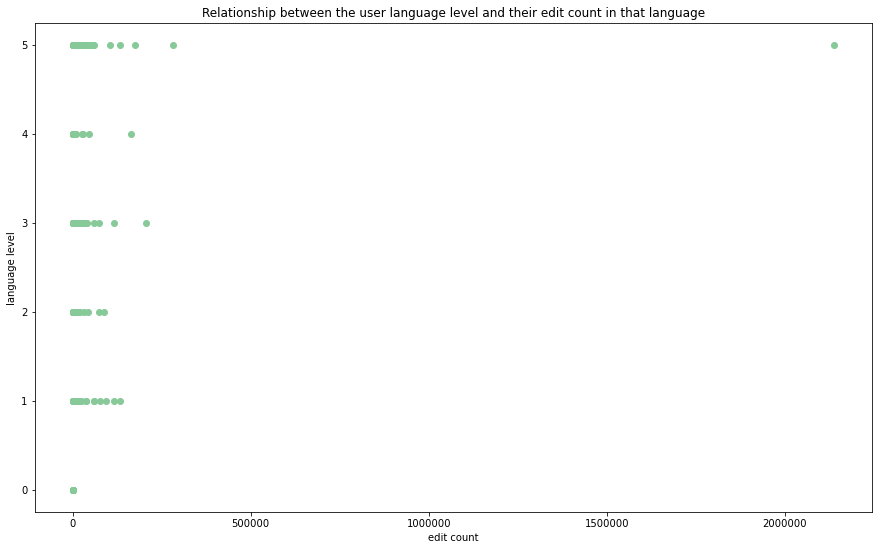

In [53]:
plt.scatter(df_users['edit_count'], df_users['level'], color = '#88c999')
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_xaxis().get_major_formatter().set_scientific(False)

plt.rcParams["figure.figsize"] = (15,8)
plt.title("Relationship between the user language level and their edit count in that language")
plt.xlabel("edit count")
plt.ylabel("language level")
plt.show()

__Observations:__ []

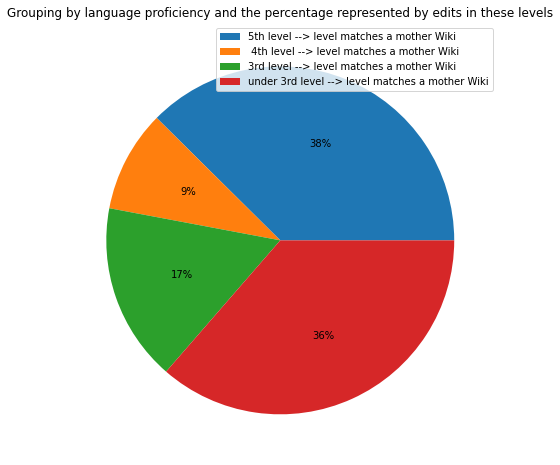

In [57]:
## Display pie

native_high_count_group = df_users.loc[(df_users['level'] == 5) & (df_users['edit count percentage'] > 65.0)]
proficient_high_count_group =  df_users.loc[(df_users['level'] == 4) & (df_users['edit count percentage'] > 65.0)]
sufficient_high_count_group =  df_users.loc[(df_users['level'] == 3) & (df_users['edit count percentage'] > 65.0)]
low_high_count_group =  df_users.loc[(df_users['level'] < 3) & (df_users['edit count percentage'] > 65.0)]

# get counts
counts_list = [native_high_count_group, proficient_high_count_group, sufficient_high_count_group, low_high_count_group]
counts_list_language_edit_number = [len(c) for c in counts_list]

# set labels
summary_labels = ["5th level --> level matches a mother Wiki", 
                  " 4th level --> level matches a mother Wiki", 
                  "3rd level --> level matches a mother Wiki", 
                  "under 3rd level --> level matches a mother Wiki"]

plt.rcParams["figure.figsize"] = (20,8)
plt.title("Grouping by language proficiency and the percentage represented by edits in these levels")
plt.pie(counts_list_language_edit_number, autopct='%.0f%%')
plt.legend( summary_labels, loc='best')
plt.show() 


__Observations:__ []

In [58]:
from enum import Enum

# we ar defining categories and benchmarks to group users
class EditCategory(Enum):
    BEGINNER = 30
    INTERMEDIATE = 100     
    EXPERT = 200
    

In [64]:
## Create a new category based on absolute numbers of the edit_count column
df_users['category'] = df_users.apply(lambda row: "beginner" if (row.edit_count < EditCategory.BEGINNER.value)
                                      else "intermediate" if (row.edit_count < EditCategory.INTERMEDIATE.value) 
                                      else "expert", axis = 1)

# out
df_users

,username,language,level,edit_count,edit count percentage,category
0,Olivier LPB,fr,5,0,0.00,beginner
1,Olivier LPB,en,2,323,100.00,expert
2,Gamesmasterg9,en,5,2753,99.85,expert
3,Gamesmasterg9,hi,4,1,0.04,beginner
4,Gamesmasterg9,bn,3,0,0.00,beginner
...,...,...,...,...,...,...
1498,Porantim,es,1,0,0.00,beginner
1499,Porantim,gl,1,0,0.00,beginner
1500,Porantim,fr,0,0,0.00,beginner
1501,Kline,en,5,0,NaN,beginner


Text(0, 0.5, 'edit count')

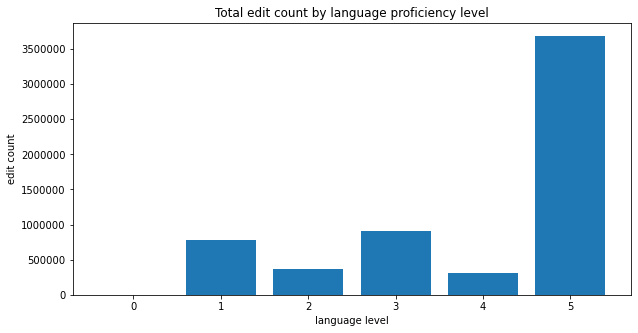

In [65]:
x = df_users.groupby(['level'], as_index=False)['edit_count'].sum()

fig = plt.figure(figsize = (10, 5))
plt.bar(x["level"], x["edit_count"])
ax = plt.gca()
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

plt.rcParams["figure.figsize"] = (20,8)
plt.title("Total edit count by language proficiency level")
plt.xlabel("language level")
plt.ylabel("edit count")

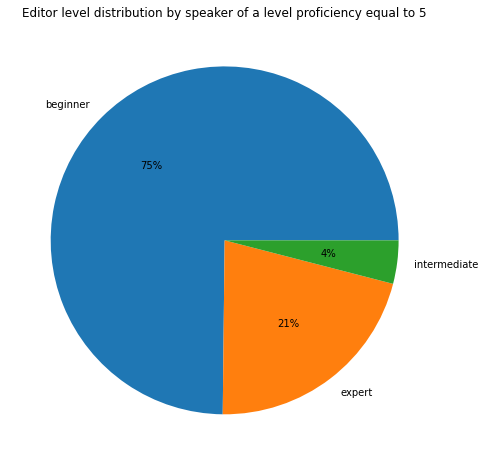

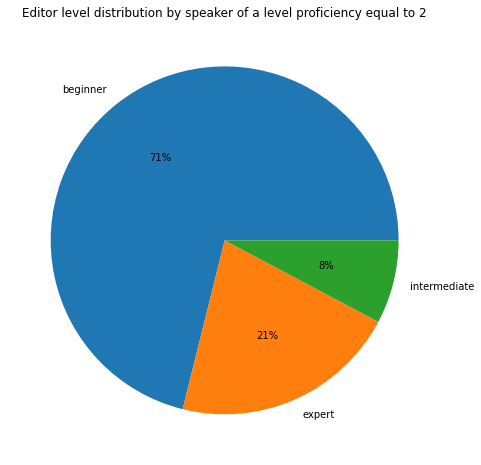

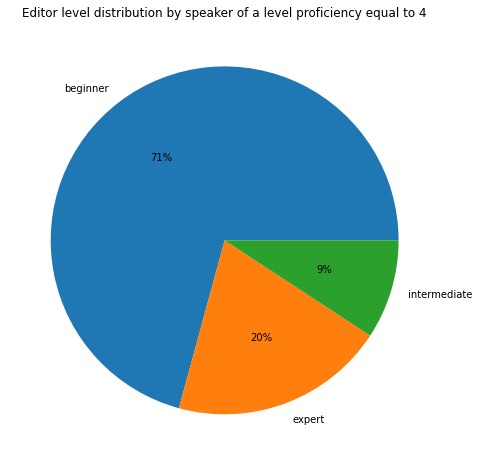

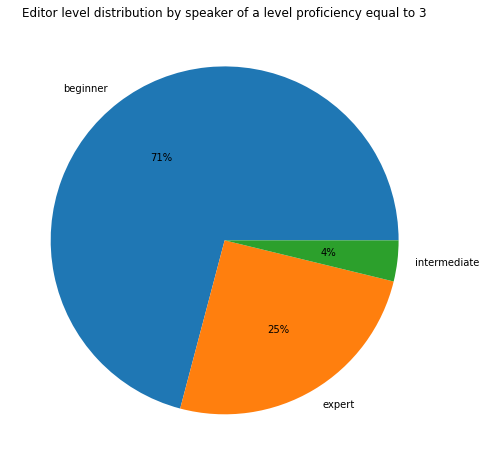

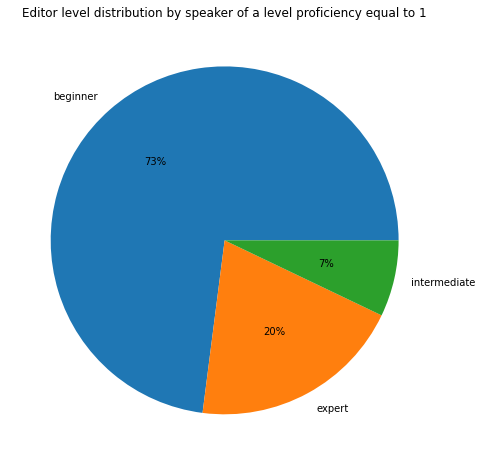

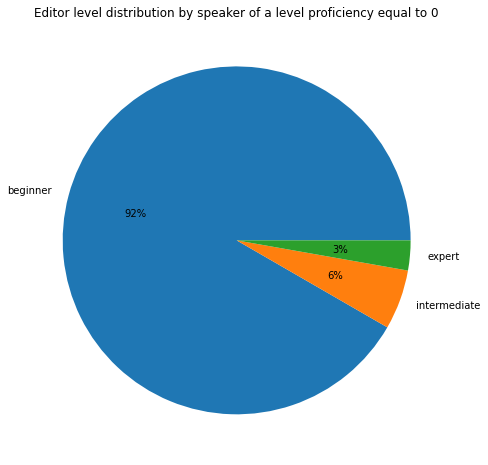

In [66]:
## Show distribution by specific language level
levels = a = df_users['level'].unique()

for level in levels:
    df = df_users.loc[(df_users['level'] == level)]
    data = df['category']
    values = data.value_counts().values.tolist()
    labels = data.value_counts().index.tolist()
    
    plt.rcParams["figure.figsize"] = (20,8)
    plt.title(f'Editor level distribution by speaker of a level proficiency equal to {level}')
    plt.pie(values, labels=labels, autopct='%.0f%%')
    plt.show()